In [1]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import tifffile
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.data.multiplex as multiplex
import mushroom.data.xenium as xenium
import mushroom.data.user_points as points
import mushroom.registration.bigwarp as bigwarp
import mushroom.utils as utils

In [5]:
project_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1'
Path(project_dir).mkdir(parents=True, exist_ok=True)

In [6]:
case = 'HT891Z1'

In [8]:
default_scale = .2

In [7]:

xenium_dir = '/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U59__20240524__182554'



In [9]:
ddf_fp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registration/s16_HT891Z1-U44_ddf.tif'


In [46]:
transcripts = pd.read_parquet(os.path.join(xenium_dir, 'transcripts.parquet'))
transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index
0,281573760961226,UNASSIGNED,0,SCD,140.161911,1461.045410,13.283036,39.839813,P6,368.310211,429
1,281573760967024,UNASSIGNED,0,KLK2,159.020187,1473.409058,13.302189,20.301004,P6,348.593689,414
2,281573760970865,UNASSIGNED,0,NKX3-1,47.234440,1481.052979,13.583780,40.000000,P6,459.963470,461
3,281573760972804,UNASSIGNED,0,NegControlProbe_00016,229.500656,1496.098999,13.366179,40.000000,P6,277.528870,13
4,281573760972859,UNASSIGNED,0,AMACR,93.003036,1472.228760,13.720614,40.000000,P6,414.576416,431
...,...,...,...,...,...,...,...,...,...,...,...
33112458,281655365342310,UNASSIGNED,0,SMARCB1,6028.867676,3566.708252,13.765719,40.000000,R15,413.389984,419
33112459,281655365349599,UNASSIGNED,0,SMARCB1,6005.048828,3500.527344,14.005056,40.000000,R15,400.723236,419
33112460,281655365350201,UNASSIGNED,0,TMPRSS2,6020.071777,3521.049561,13.678159,40.000000,R15,410.879120,475
33112461,281655365350202,UNASSIGNED,0,KLK2,6031.653809,3500.138184,13.665494,40.000000,R15,426.644989,414


In [10]:
ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, default_scale) # ddfs are (c h w)
ddf.shape

torch.Size([2, 6530, 7255])

In [104]:
%%time 
upscale_factor = 4
warped, mask = bigwarp.warp_pts_fast(transcripts[['y_location', 'x_location']].values, ddf, upscale_factor=upscale_factor)
warped.shape, mask.shape

CPU times: user 3min 19s, sys: 20.8 s, total: 3min 40s
Wall time: 3min 19s


((33112463, 2), (33112463,))

In [141]:
transcripts.head().to_parquet('/diskmnt/Projects/Users/estorrs/sandbox/test.parquet')

In [142]:
data.shape

(4, 30730, 28518)

In [143]:
channels

['DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'alphaSMA/Vimentin']

In [144]:
multiplex.write_basic_ome_tiff(
    '/diskmnt/Projects/Users/estorrs/sandbox/test.ome.tif', data, channels, microns_per_pixel=.2125
)


In [147]:
multiplex.pixels_per_micron('/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U59__20240524__182554/morphology_focus/morphology_focus_0000.ome.tif')


0.2125

In [148]:
ddf_fp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registration/s1_HT891Z1-U4_ddf.tif'
ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, .2) # ddfs are (c h w)

In [165]:
multiplex.pixels_per_micron('/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U2__20240812.ome.tiff')

0.5100762527233116

In [164]:
channels, data = multiplex.extract_ome_tiff('/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U2__20240812.ome.tiff', as_dict=False, channels=['DAPI'])
data.shape

(1, 13490, 16950)

In [172]:
sf = data.shape[-2] / ddf.shape[-2] 
up_ddf = utils.rescale(ddf, size=data.shape[-2:], dim_order='c h w', target_dtype=ddf.dtype)
# up_ddf *= sf
warped = bigwarp.register_multiplex(data, up_ddf, grid_scaler=sf)

In [173]:
warped.shape

(1, 13490, 16950)

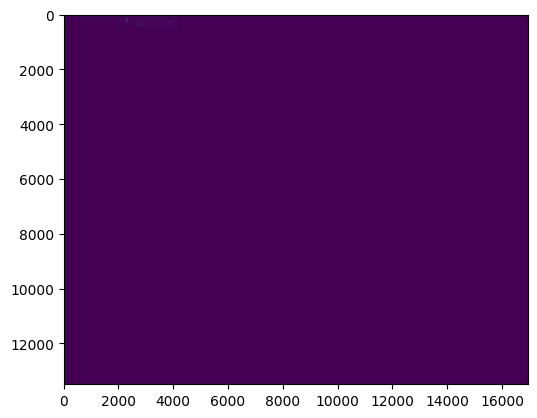

In [174]:
plt.imshow(warped[0])

In [157]:
sf

2.0658499234303216

In [105]:
focus_dir = Path(xenium_dir) / 'morphology_focus'

In [106]:
focus_dir.exists()

True

In [111]:
data.shape[-2:]

(30730, 28518)

In [116]:
from ome_types import from_xml
from tifffile import TiffFile
tif = TiffFile(focus_dir / names[0])
ome = from_xml(tif.ome_metadata)

In [123]:
ome.images[0].pixels.channels

[Channel(
    id='Channel:0',
    name='DAPI',
    annotation_refs=[{'id': 'Annotation:0'}],
    samples_per_pixel=1,
 ),
 Channel(
    id='Channel:1',
    name='ATP1A1/CD45/E-Cadherin',
    annotation_refs=[{'id': 'Annotation:1'}],
    samples_per_pixel=1,
 ),
 Channel(
    id='Channel:2',
    name='18S',
    annotation_refs=[{'id': 'Annotation:2'}],
    samples_per_pixel=1,
 ),
 Channel(
    id='Channel:3',
    name='alphaSMA/Vimentin',
    annotation_refs=[{'id': 'Annotation:3'}],
    samples_per_pixel=1,
 )]

In [126]:
p = tif.pages[0]
p

<tifffile.TiffPage 0 @16>

In [128]:
p.shape

(30730, 28518)

In [129]:
x = tifffile.imread(focus_dir / names[0])
x.shape

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


(4, 30730, 28518)

In [130]:
len(tif.series)

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


1

In [131]:
s = tif.series[0]
s

<tifffile.TiffPageSeries 0 ome>

In [132]:
s.shape

(4, 30730, 28518)

In [134]:
len(s.pages)

4

In [137]:
names = [name for name in os.listdir(focus_dir) if '.tif' in name]
if names:
    channels, data = multiplex.extract_ome_tiff(focus_dir / names[0], as_dict=False)
    resized_ddf = utils.rescale(ddf, size=data.shape[-2:], dim_order='c h w', target_dtype=ddf.dtype)
    data = bigwarp.register_multiplex(data, resized_ddf)
    

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/tifffile/tifffile.py:9005: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(


In [138]:
channels

['DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'alphaSMA/Vimentin']

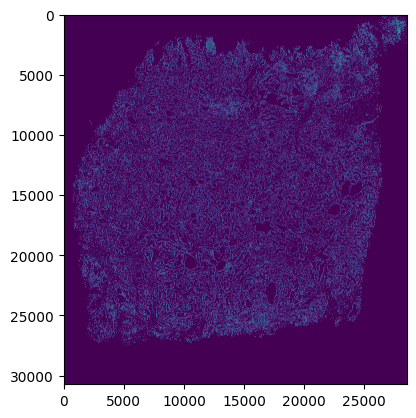

In [139]:
plt.imshow(data[0])

In [140]:
data.shape

(4, 30730, 28518)

In [75]:
ddf[0, 5000:5010, 3000:3010]

tensor([[304.3275, 304.3163, 304.3052, 304.2941, 304.2830, 304.2718, 304.2607,
         304.2496, 304.2385, 304.2274],
        [304.3037, 304.2926, 304.2815, 304.2704, 304.2593, 304.2482, 304.2371,
         304.2260, 304.2148, 304.2037],
        [304.2801, 304.2690, 304.2578, 304.2468, 304.2356, 304.2245, 304.2134,
         304.2023, 304.1912, 304.1801],
        [304.2564, 304.2453, 304.2342, 304.2231, 304.2120, 304.2009, 304.1898,
         304.1787, 304.1676, 304.1565],
        [304.2327, 304.2216, 304.2105, 304.1994, 304.1883, 304.1772, 304.1661,
         304.1550, 304.1440, 304.1328],
        [304.2090, 304.1979, 304.1868, 304.1758, 304.1646, 304.1536, 304.1425,
         304.1314, 304.1203, 304.1092],
        [304.1853, 304.1743, 304.1632, 304.1521, 304.1410, 304.1299, 304.1188,
         304.1078, 304.0967, 304.0856],
        [304.1616, 304.1506, 304.1395, 304.1284, 304.1173, 304.1063, 304.0952,
         304.0841, 304.0731, 304.0620],
        [304.1379, 304.1269, 304.1158, 304.1047,

In [84]:
upscale_factor = 4
up_ddf = utils.rescale(ddf, scale=upscale_factor, dim_order='c h w', target_dtype=ddf.dtype).numpy()
up_ddf.shape

(2, 26120, 29020)

In [61]:
r1, r2, c1, c2 = 1600, 2000, 2900, 3600
# mask = (transcripts['y_location'] > r1)  & (transcripts['y_location'] < r2)
# mask &= (transcripts['x_location'] > c1)  & (transcripts['x_location'] < c2)
# small = transcripts[mask]
small = transcripts[transcripts['feature_name']=='EPCAM']
small

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index
128,281573760961223,UNASSIGNED,0,EPCAM,8.315326,1943.578125,13.761968,28.952623,P6,389.352570,278
129,281573760961228,UNASSIGNED,0,EPCAM,204.624390,1918.069702,13.580087,40.000000,P6,199.742310,278
522,281616710651279,khaahcff-1,0,EPCAM,209.592041,2735.886719,19.796257,40.000000,Q6,0.217130,278
523,281616710651281,khaahcff-1,1,EPCAM,210.839813,2735.288330,17.191624,40.000000,Q6,0.000000,278
525,281616710651306,khaaipnn-1,1,EPCAM,232.334686,2743.859131,18.328569,40.000000,Q6,0.000000,278
...,...,...,...,...,...,...,...,...,...,...,...
33110711,281530811290895,UNASSIGNED,0,EPCAM,5815.369141,1067.966431,13.403363,28.952623,O15,215.964920,278
33110860,281569465992790,UNASSIGNED,0,EPCAM,5996.617188,1686.906616,13.362648,28.589491,P15,204.085236,278
33111248,281612415681101,UNASSIGNED,0,EPCAM,5804.253418,2598.883301,14.059476,25.155937,Q15,170.224670,278
33111477,281655365350199,UNASSIGNED,0,EPCAM,5986.812500,3402.534912,14.498569,40.000000,R15,398.462524,278


(-291.09976735115055, 6296.03228058815, 6765.014133310318, -307.6630104541779)

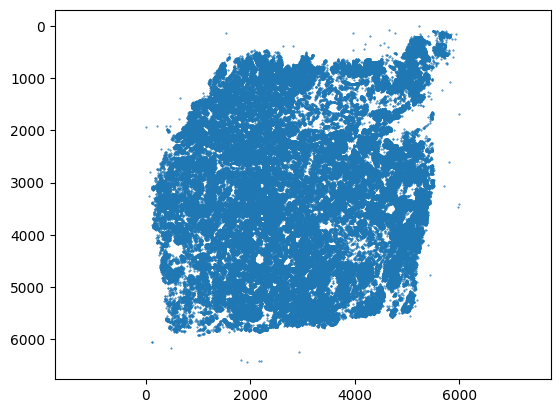

In [62]:
import matplotlib.pyplot as plt
plt.scatter(small['x_location'], small['y_location'], s=.2)
plt.gca().invert_yaxis()
plt.axis('equal')

In [85]:
def transform(x):
#     r, c = x
#     print(x, )
#     print(up_ddf[:, int(x[0] * upscale_factor), int(x[1] * upscale_factor)])
    return x + up_ddf[:, int(x[0] * upscale_factor), int(x[1] * upscale_factor)]

In [86]:
out = np.apply_along_axis(transform, 1, small[['y_location', 'x_location']].values)

In [102]:
out, mask = bigwarp.warp_pts_fast(small[['y_location', 'x_location']].values, ddf, upscale_factor=upscale_factor)

In [99]:
out, mask = bigwarp.warp_pts_fast(np.asarray([[10000, 5]]), ddf, upscale_factor=upscale_factor)

In [103]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

(-472.8069160461426, 5749.255081939697, 7039.674816894531, 17.88255615234374)

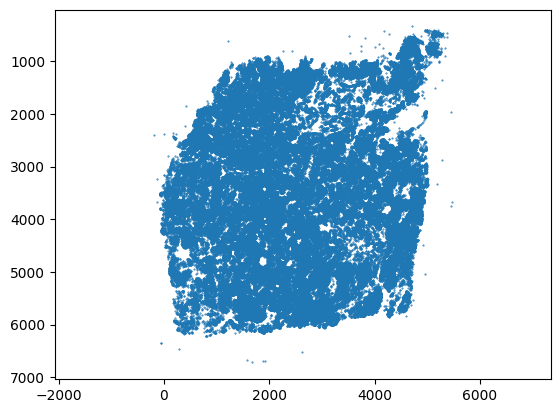

In [95]:
import matplotlib.pyplot as plt
plt.scatter(out[:, 1], out[:, 0], s=.2)
plt.gca().invert_yaxis()
plt.axis('equal')

In [89]:
adata = xenium.adata_from_xenium(xenium_dir)
adata

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


AnnData object with n_obs × n_vars = 206538 × 476
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'ppm'
    obsm: 'spatial'

In [91]:
adata.obsm['spatial']

array([[ 526, 2344],
       [ 547, 2371],
       [ 545, 2359],
       ...,
       [3728, 1808],
       [3722, 1842],
       [3738, 1827]])

In [ ]:
plt.scatter(adata.obsm['spatial'][:, 0])

In [11]:
ddf[0]

tensor([[509.6768, 509.6768, 509.6768,  ..., 265.9851, 265.9851, 265.9851],
        [509.6768, 509.6768, 509.6768,  ..., 265.9851, 265.9851, 265.9851],
        [509.6768, 509.6768, 509.6768,  ..., 265.9851, 265.9851, 265.9851],
        ...,
        [302.3517, 302.3517, 302.3517,  ..., 214.6678, 214.6678, 214.6678],
        [302.3517, 302.3517, 302.3517,  ..., 214.6678, 214.6678, 214.6678],
        [302.3517, 302.3517, 302.3517,  ..., 214.6678, 214.6678, 214.6678]])

In [12]:
ddf[1]

tensor([[-216.7173, -216.7173, -216.7173,  ..., -620.0582, -620.0582,
         -620.0582],
        [-216.7173, -216.7173, -216.7173,  ..., -620.0582, -620.0582,
         -620.0582],
        [-216.7173, -216.7173, -216.7173,  ..., -620.0582, -620.0582,
         -620.0582],
        ...,
        [-150.7934, -150.7934, -150.7934,  ..., -566.0980, -566.0980,
         -566.0980],
        [-150.7934, -150.7934, -150.7934,  ..., -566.0980, -566.0980,
         -566.0980],
        [-150.7934, -150.7934, -150.7934,  ..., -566.0980, -566.0980,
         -566.0980]])

In [43]:
ddf[0][:10, :10]

tensor([[509.6768, 509.6768, 509.6768, 509.6539, 509.6310, 509.6080, 509.5850,
         509.5621, 509.5392, 509.5162],
        [509.6768, 509.6768, 509.6768, 509.6539, 509.6310, 509.6080, 509.5850,
         509.5621, 509.5392, 509.5162],
        [509.6768, 509.6768, 509.6768, 509.6539, 509.6310, 509.6080, 509.5850,
         509.5621, 509.5392, 509.5162],
        [509.6560, 509.6560, 509.6560, 509.6331, 509.6102, 509.5872, 509.5642,
         509.5413, 509.5184, 509.4954],
        [509.6353, 509.6353, 509.6353, 509.6124, 509.5894, 509.5665, 509.5435,
         509.5206, 509.4977, 509.4747],
        [509.6145, 509.6145, 509.6145, 509.5916, 509.5686, 509.5457, 509.5228,
         509.4998, 509.4769, 509.4539],
        [509.5937, 509.5937, 509.5937, 509.5708, 509.5479, 509.5249, 509.5020,
         509.4791, 509.4561, 509.4332],
        [509.5729, 509.5729, 509.5729, 509.5500, 509.5271, 509.5042, 509.4812,
         509.4583, 509.4354, 509.4124],
        [509.5522, 509.5522, 509.5522, 509.5292,

In [14]:
ddf[0][1000:1010, 1000:1005]

tensor([[464.5106, 464.4859, 464.4612, 464.4364, 464.4117],
        [464.4875, 464.4628, 464.4381, 464.4134, 464.3886],
        [464.4644, 464.4398, 464.4150, 464.3903, 464.3655],
        [464.4413, 464.4167, 464.3919, 464.3672, 464.3424],
        [464.4182, 464.3936, 464.3688, 464.3441, 464.3193],
        [464.3951, 464.3704, 464.3457, 464.3210, 464.2962],
        [464.3719, 464.3473, 464.3226, 464.2978, 464.2731],
        [464.3488, 464.3242, 464.2995, 464.2747, 464.2500],
        [464.3257, 464.3010, 464.2763, 464.2516, 464.2269],
        [464.3025, 464.2778, 464.2532, 464.2285, 464.2037]])

In [29]:
unraveled = rearrange(ddf, 'c h w -> (h w) c')
unraveled.shape

torch.Size([47375150, 2])

In [30]:
y = unraveled[:, 0]

In [33]:
X = np.stack(np.meshgrid(np.arange(ddf.shape[-2]), np.arange(ddf.shape[-1]), indexing='ij'))
X = rearrange(X, 'c h w -> (h w) c')
X.shape

(47375150, 2)

In [44]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# #X is the independent variable (bivariate in this case)
# X = np.array([[0.44, 0.68], [0.99, 0.23]])

# #vector is the dependent data
# vector = np.array([109.85, 155.72])

#predict is an independent variable for which we'd like to predict the value
predict= np.array([[10., 11.]])

#generate a model of polynomial features
poly = PolynomialFeatures(degree=4)

#transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
X_ = poly.fit_transform(X)

#transform the prediction to fit the model type
predict_ = poly.transform(predict)

#here we can remove polynomial orders we don't want
#for instance I'm removing the `x` component
# X_ = np.delete(X_,(1),axis=1)
# predict_ = np.delete(predict_,(1),axis=1)

#generate the regression object
clf = linear_model.LinearRegression()
#preform the actual regression
clf.fit(X_, y)

# print("X_ = ",X_)
# print("predict_ = ",predict_)
# print("Prediction = ",clf.predict(predict_))

LinearRegression()

In [45]:
clf.predict(poly.transform([[1, 1]]))

array([500.41469575])

In [42]:
clf.predict(poly.transform([[10, 10]]))

array([528.73230023])

In [ ]:
np.polynomial()

In [25]:
from numpy.polynomial import Chebyshev, Polynomial

p = Polynomial.fit(X[:, 0], X[:, 1], deg=2)
p

Polynomial([-310.89594,  162.46028, -151.79172], dtype=float32, domain=[214.66785, 509.67682], dtype=float32, window=[-1.,  1.])

In [27]:
p(1)

-1618.74105210302

In [ ]:
adata = xenium.adata_from_xenium(fp)

adata = bigwarp.register_xenium(
    adata, ddf, resolution=res
)

In [7]:
transcripts_fp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registered/s7_HT913Z1-U11_xenium_transcripts.parquet'
cells_fp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registered/s7_HT913Z1-U11_xenium.h5ad'
morph_fp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registered/s7_HT913Z1-U11_xenium_morphologyfocus.ome.tiff'





In [8]:
transcripts = pd.read_parquet(transcripts_fp)
small = transcripts[transcripts['feature_name']=='EPCAM']
small

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
757,281642480736784,ahndamfi-1,0,EPCAM,200.0,2480.0,16.203125,40.00,P3,1.031250,10970,predesigned_gene,True
758,281642480736786,ahndamfi-1,0,EPCAM,200.0,2481.0,18.406250,33.25,P3,1.328125,10970,predesigned_gene,True
759,281642480987942,ahnepoec-1,1,EPCAM,200.0,2482.0,16.890625,40.00,P3,0.000000,10970,predesigned_gene,True
14826,281582351162346,gmkdhkdi-1,0,EPCAM,414.0,1528.0,15.734375,40.00,O3,0.109375,728,predesigned_gene,True
14827,281582351184083,gmkldhik-1,1,EPCAM,412.0,1589.0,18.109375,40.00,O3,0.000000,728,predesigned_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180395478,281960308629529,kmeindcl-1,1,EPCAM,8106.0,6465.0,20.296875,40.00,V16,0.000000,12166,predesigned_gene,True
180488037,281578056294351,UNASSIGNED,0,EPCAM,8308.0,1519.0,15.296875,40.00,O16,224.218750,12166,predesigned_gene,True
180488219,281638186078555,UNASSIGNED,0,EPCAM,8230.0,2003.0,15.468750,40.00,P16,124.953125,10970,predesigned_gene,True
180489011,281874409835101,UNASSIGNED,0,EPCAM,8412.0,4857.0,14.765625,40.00,T16,189.312500,10970,predesigned_gene,True


In [9]:
adata = xenium.adata_from_xenium(cells_fp)
adata

AnnData object with n_obs × n_vars = 300152 × 5001
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial'
    obsm: 'spatial', 'spatial_original'

In [10]:
channels, data = multiplex.extract_ome_tiff(morph_fp, channels=['DAPI'], as_dict=False)
data.shape

(1, 6530, 8460)

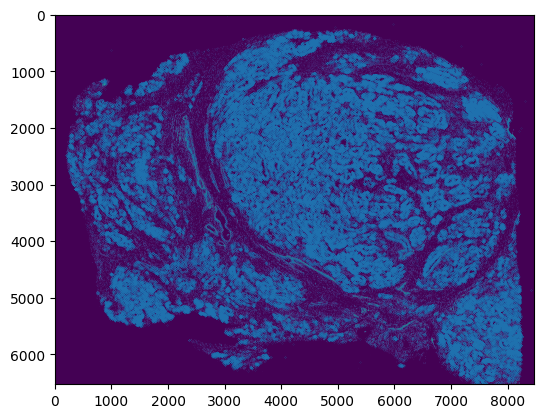

In [12]:
import matplotlib.pyplot as plt
plt.imshow(data[0])
plt.scatter(small['x_location'], small['y_location'], s=.01)


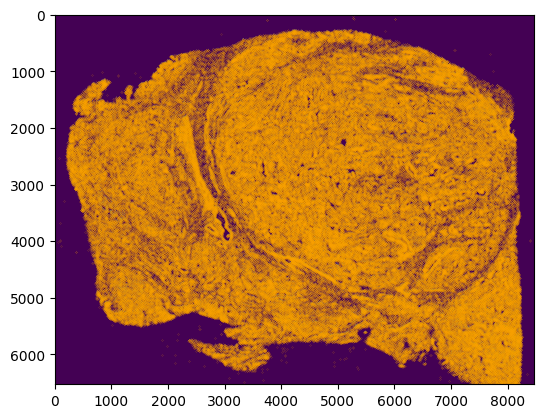

In [13]:
plt.imshow(data[0])
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=.01, c='orange')

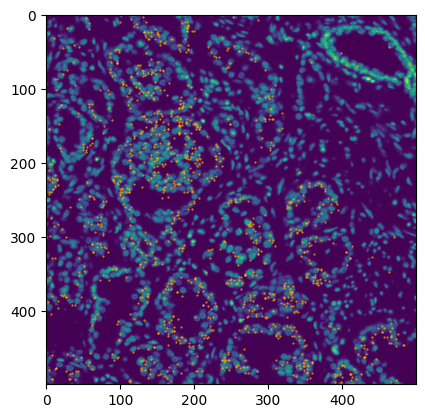

In [15]:
r1, r2, c1, c2 = 4000, 4500, 2500, 3000

plt.imshow(data[0, r1:r2, c1:c2])

mask = small['x_location'] > c1
mask &= small['x_location'] < c2
mask &= small['y_location'] > r1
mask &= small['y_location'] < r2

plt.scatter(small[mask]['x_location'] - c1, small[mask]['y_location'] - r1, s=.2, color='orange')

In [201]:
small[mask]

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
